In [1]:
# initialize environment for reproducibility

import torch
import random

random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda:1')

In [2]:
# format: filename index_of_slice
trainlistpath = "/home/lyy/moco/datasets/.Fastmri_pics/trainlist.txt"
vallistpath = "/home/lyy/moco/datasets/.Fastmri_pics/vallist.txt"
testlistpath = "/home/lyy/moco/datasets/.Fastmri_pics/testlist.txt"
showlistpath = "/home/lyy/moco/datasets/.Fastmri_pics/showlist.txt"

with open(trainlistpath, 'r') as f:
    trainlist = f.readlines()
    trainlist = [(line.split()[0], int(line.split()[1])) for line in trainlist]

with open(vallistpath, 'r') as f:
    vallist = f.readlines()
    vallist = [(line.split()[0], int(line.split()[1])) for line in vallist]

with open(testlistpath, 'r') as f:
    testlist = f.readlines()
    testlist = [(line.split()[0], int(line.split()[1])) for line in testlist]

with open(showlistpath, 'r') as f:
    showlist = f.readlines()
    showlist = [(line.split()[0], int(line.split()[1])) for line in showlist]

print("file in trainlist: ", len(trainlist))
print("file in vallist: ", len(vallist))
print("file in testlist: ", len(testlist))
print("file in showlist: ", len(showlist))

file in trainlist:  12344
file in vallist:  3764
file in testlist:  1464
file in showlist:  2


In [3]:
# loadtransform
from torch import nn


load_keys = ['kspace']

class Loadtransform(nn.Module):
    """Load the data to the memory"""
    def __init__(self):
        super().__init__()

    def forward(self, data):
        # input: ismrmrd_header rss csm kspace
        return {'kspace': data['kspace'].to(torch.complex64)}


In [4]:
# data augmentation transform

import torch
from torch import nn
from torchvision import transforms as tf

from models.mynn import functional as myf
from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function, ToepNufft

from einops import rearrange, repeat


class Motion(nn.Module):
    def __init__(self, image_size = (320, 320),
                 motion_ratio = [1, 1, 1, 1, 1], rot = 15, shift = (0.05, 0.05), scale = (0.01, 0.01), shear = (0.01, 0.01),
                 num_spokes_full = 500, num_spokes_partial = 20, num_pts_readout = 320, oversampling_factor = 2,
                 dtype = torch.complex64, device = torch.device('cuda')):
        super().__init__()
        self.image_size = image_size
        self.rot = rot
        self.shift = shift
        self.scale = scale
        self.shear = shear
        self.num_spokes_full = num_spokes_full
        self.num_spokes_partial = num_spokes_partial
        self.num_pts_readout = num_pts_readout
        self.oversampling_factor = oversampling_factor
        self.dtype = dtype
        self.device = device

        self.float_dtype = torch.float32 if dtype == torch.complex64 else torch.float64

        self.num_motion_states = len(motion_ratio)
        self.motion_partition = [0]
        for ratio in motion_ratio:
            self.motion_partition.append(self.motion_partition[-1] + ratio / sum(motion_ratio))
        
        self.random_motion = tf.RandomAffine(degrees=rot, translate=shift, scale=scale, shear=shear, fill=0).to(device)
        self._nufft_obj = KbNufft(im_size=image_size, dtype=dtype, device=device)
        self._inufft_obj = KbNufftAdjoint(im_size=image_size, dtype=dtype, device=device)

        self.traj_full = self.gatraj().to(device).to(self.float_dtype)
        self.traj_partial = self.traj_full[:self.num_spokes_partial]

    def move(self, image):
        """ input: batch, channel, height, width
            output: motion_state, batch, channel, height, width
        """
        image = myf.complex_to_real(image) # batch, channel * 2, height, width
        resl = torch.zeros((self.num_motion_states+1), *image.shape, dtype=image.dtype, device=image.device) # motion_state batch, channel, height, width
        resl[0] = image
        for i in range(self.num_motion_states):
            resl[i+1] = self.random_motion(image)
        resl = myf.real_to_complex(resl) # motion_state, batch, channel, height, width
        return resl
    
    def gatraj(self):
        """Get golden angle trajectory"""
        import sys
        import os
        sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
        from bart import bart
        traj = bart(1, f'traj -x {self.num_pts_readout} -y {self.num_spokes_full} -r -G -o {self.oversampling_factor}')
        traj = torch.tensor(traj)[:2, :, :].real
        traj = rearrange(traj, 'pos readout phase -> phase readout pos')
        return traj

    def ft(self, image, ktraj):
        ktraj_shape = ktraj.shape
        ktraj = ktraj / self.num_pts_readout * 2 * torch.pi # bart normalization to torchkbnufft normalization
        ktraj = rearrange(ktraj, 'phase readout pos -> pos (phase readout)')

        # batched nufft
        original_shape = image.shape
        image = rearrange(image, '... channel phase readout -> (...) channel phase readout') # nufft only accept [b h w] input

        res = torch.cat([self._nufft_obj(image[i].unsqueeze(0), ktraj) for i in range(image.shape[0])], dim = 0).view(*original_shape[:-2], ktraj_shape[0], ktraj_shape[1]) # ... phase readout
        return res
    
    def ift(self, kspace, ktraj):
        ktraj_shape = ktraj.shape
        ktraj = ktraj / self.num_pts_readout * 2 * torch.pi
        ktraj = rearrange(ktraj, 'phase readout pos -> pos (phase readout)')

        interp_mats = calc_tensor_spmatrix(ktraj,im_size=self.image_size, table_oversamp=2)
        dcomp = calc_density_compensation_function(ktraj=ktraj, im_size=self.image_size)

        # batched inufft
        original_shape = kspace.shape

        kspace = rearrange(kspace, '... channel phase readout -> (...) channel (phase readout)') # inufft only accept [b pts] input

        res = torch.cat([self._inufft_obj(kspace[i].unsqueeze(0) * dcomp, ktraj, interp_mats) for i in range(kspace.shape[0])], dim=0).view(*original_shape[:-2], *self.image_size) # ... height width
        return res

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.move(image) # motion_state, batch, channel, height, width
        kspace = self.ft(image, self.traj_full) # motion_state, batch, channel, phase, readout

        indices = torch.randperm(kspace.shape[-2])
        kspace_mixed = torch.zeros_like(kspace[0]) # batch, channel, phase, readout
        for state in range(self.num_motion_states):
            kspace_mixed[:, :, indices[int(self.motion_partition[state] * indices.shape[0]):int(self.motion_partition[state+1] * indices.shape[0])], :] \
                = kspace[state][:, :, indices[int(self.motion_partition[state] * indices.shape[0]):int(self.motion_partition[state+1] * indices.shape[0])] , :]

        image = self.ift(kspace_mixed, self.traj_full)
        return image, kspace_mixed


class DataAugmentation(nn.Module):
    """Computationally Intensive Transformations"""
    def __init__(self, motion_simulator: nn.Module):
        super().__init__()
        self.motion_simulator = motion_simulator

    def mean_std_norm_complex(self, data: torch.Tensor) -> torch.Tensor:
        real = data.real
        imag = data.imag
        real = (real - real.mean()) / real.std()
        imag = (imag - imag.mean()) / imag.std()
        return real + 1j * imag

    def forward(self, data):
        kspace = data['kspace']
        image = myf.ktoi(kspace)
        image = self.mean_std_norm_complex(image)
        kspace = myf.itok(image)
        image_after, kspace_after = self.motion_simulator(image)
        image_after = self.mean_std_norm_complex(image_after)
        return {"kspace_before":kspace, "kspace_after":kspace_after, "image_before":image, "image_after":image_after}




/home/lyy/miniconda3/envs/moco/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
[2024/12/24 05:00:47][unet_radial_moco_train_20241224050047][DEBUG]logger unet_radial_moco_train_20241224050047 configuration done. Log file: exp/unet_radial_moco_train_20241224050047/train.log, Log level: 10, Console log level: 10, File log level: 20.
[2024/12/24 05:00:47][unet_radial_moco_train_20241224050047][DEBUG]|||||Trainer now using device: cuda:1|||||
[2024/12/24 05:00:47][unet_radial_moco_train_20241224050047][DEBUG]Total batches: train_loader 1543 , val_loader 471, and epoch length is 80.
[2024/12/24 05:00:47][unet_radial_moco_train_20241224050047][DEBUG]|-
train:
  exp_name: unet_radial_moco
  batch_size: 8
  epoch: 11
  learning_rate: 0.0

imshowing showset_before device: cuda:1


[2024/12/24 05:01:06][unet_radial_moco_train_20241224050047][INFO]Training started. Time: 2024-12-24 05:01:06.918306
[2024/12/24 05:08:13][unet_radial_moco_train_20241224050047][DEBUG]Epoch[1/11] run train evaluator.
[2024/12/24 05:08:49][unet_radial_moco_train_20241224050047][INFO]Training Results - Epoch[1/11] ssim: nan psnr: nan loss: nan
[2024/12/24 05:08:49][unet_radial_moco_train_20241224050047][DEBUG]Epoch[1/11] run val evaluator.
[2024/12/24 05:09:52][unet_radial_moco_train_20241224050047][INFO]Validation Results - Epoch[1/11] ssim: nan psnr: nan loss: nan
[2024/12/24 05:09:52][unet_radial_moco_train_20241224050047][DEBUG]Epoch[1/11] run tb_imshow_evaluator.
[2024/12/24 05:09:55][unet_radial_moco_train_20241224050047][DEBUG]Epoch[1/11] tb_iter 1, run imshow_process.
/home/lyy/miniconda3/envs/moco/lib/python3.10/site-packages/torch/utils/tensorboard/summary.py:576: RuntimeWarning: invalid value encountered in cast
  tensor = (tensor * scale_factor).clip(0, 255).astype(np.uint8)


imshowing testcase_trainset device: cuda:1
imshowing testcase_valset device: cuda:1
imshowing testcase_tb device: cuda:1


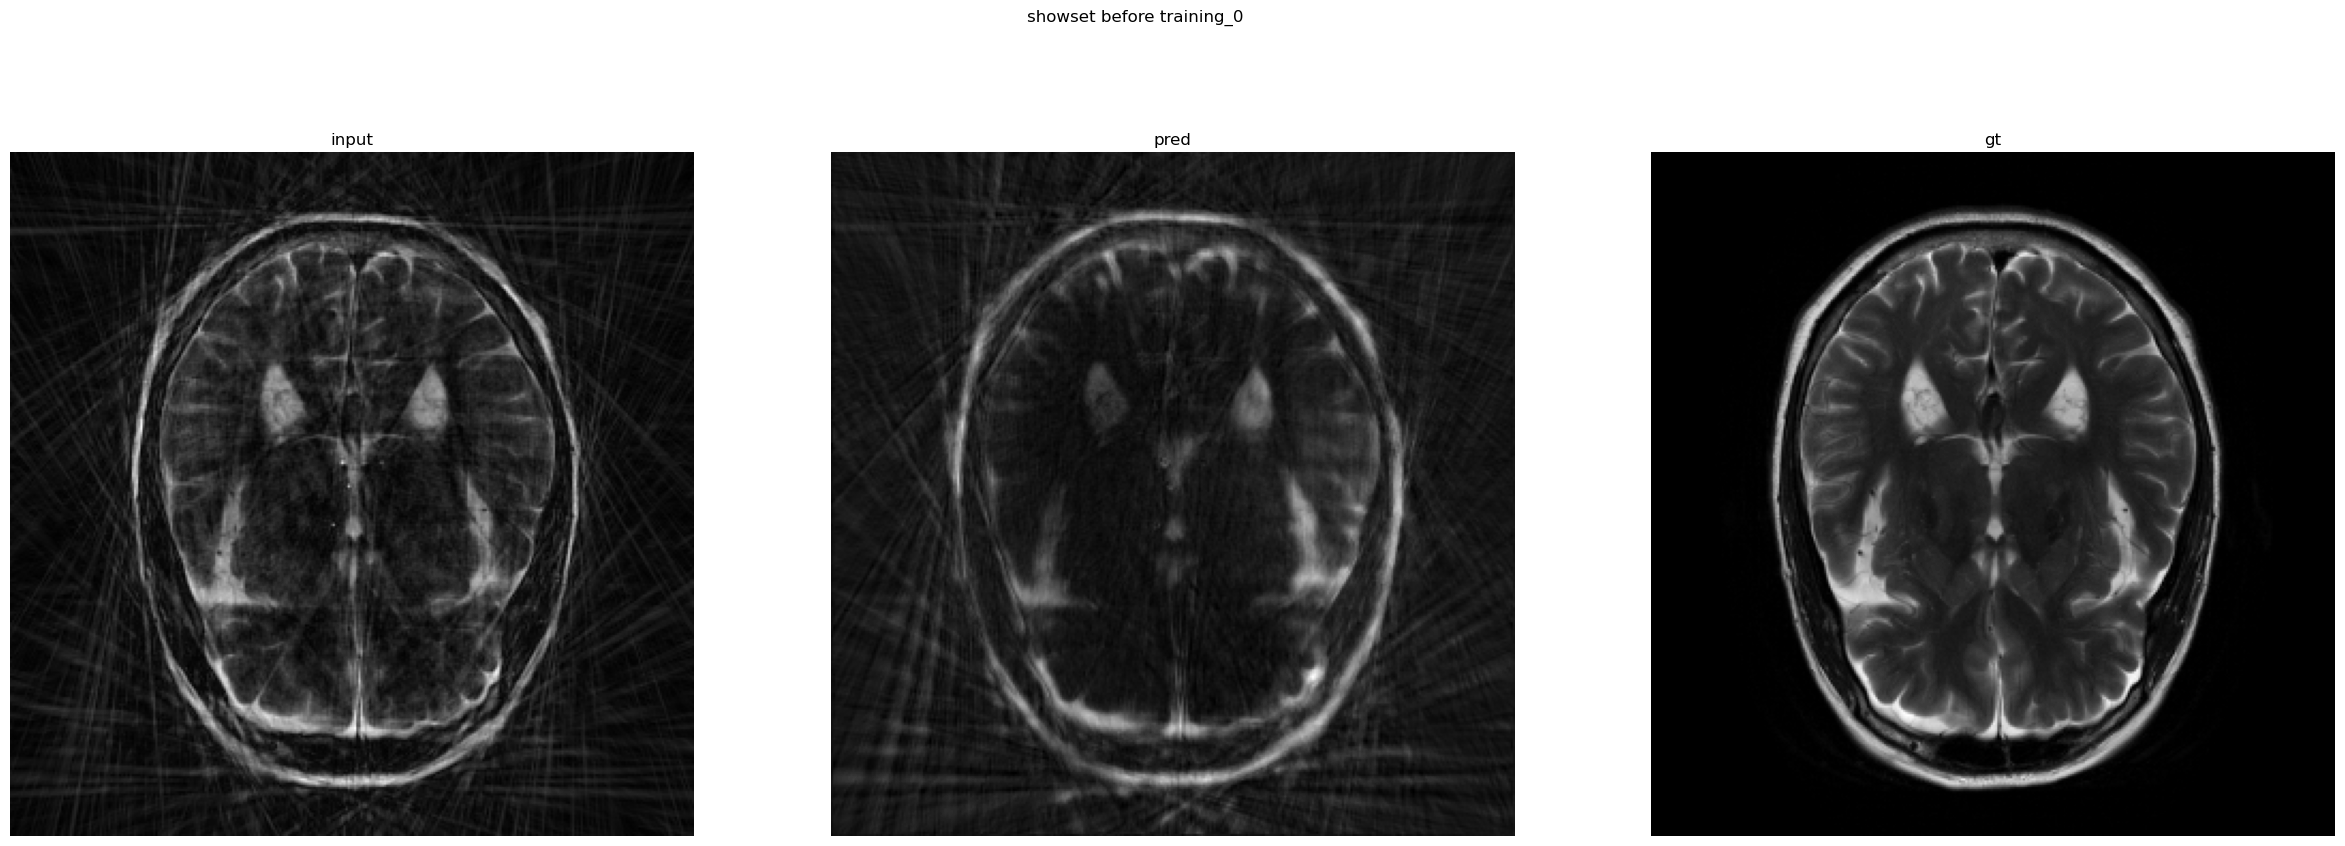

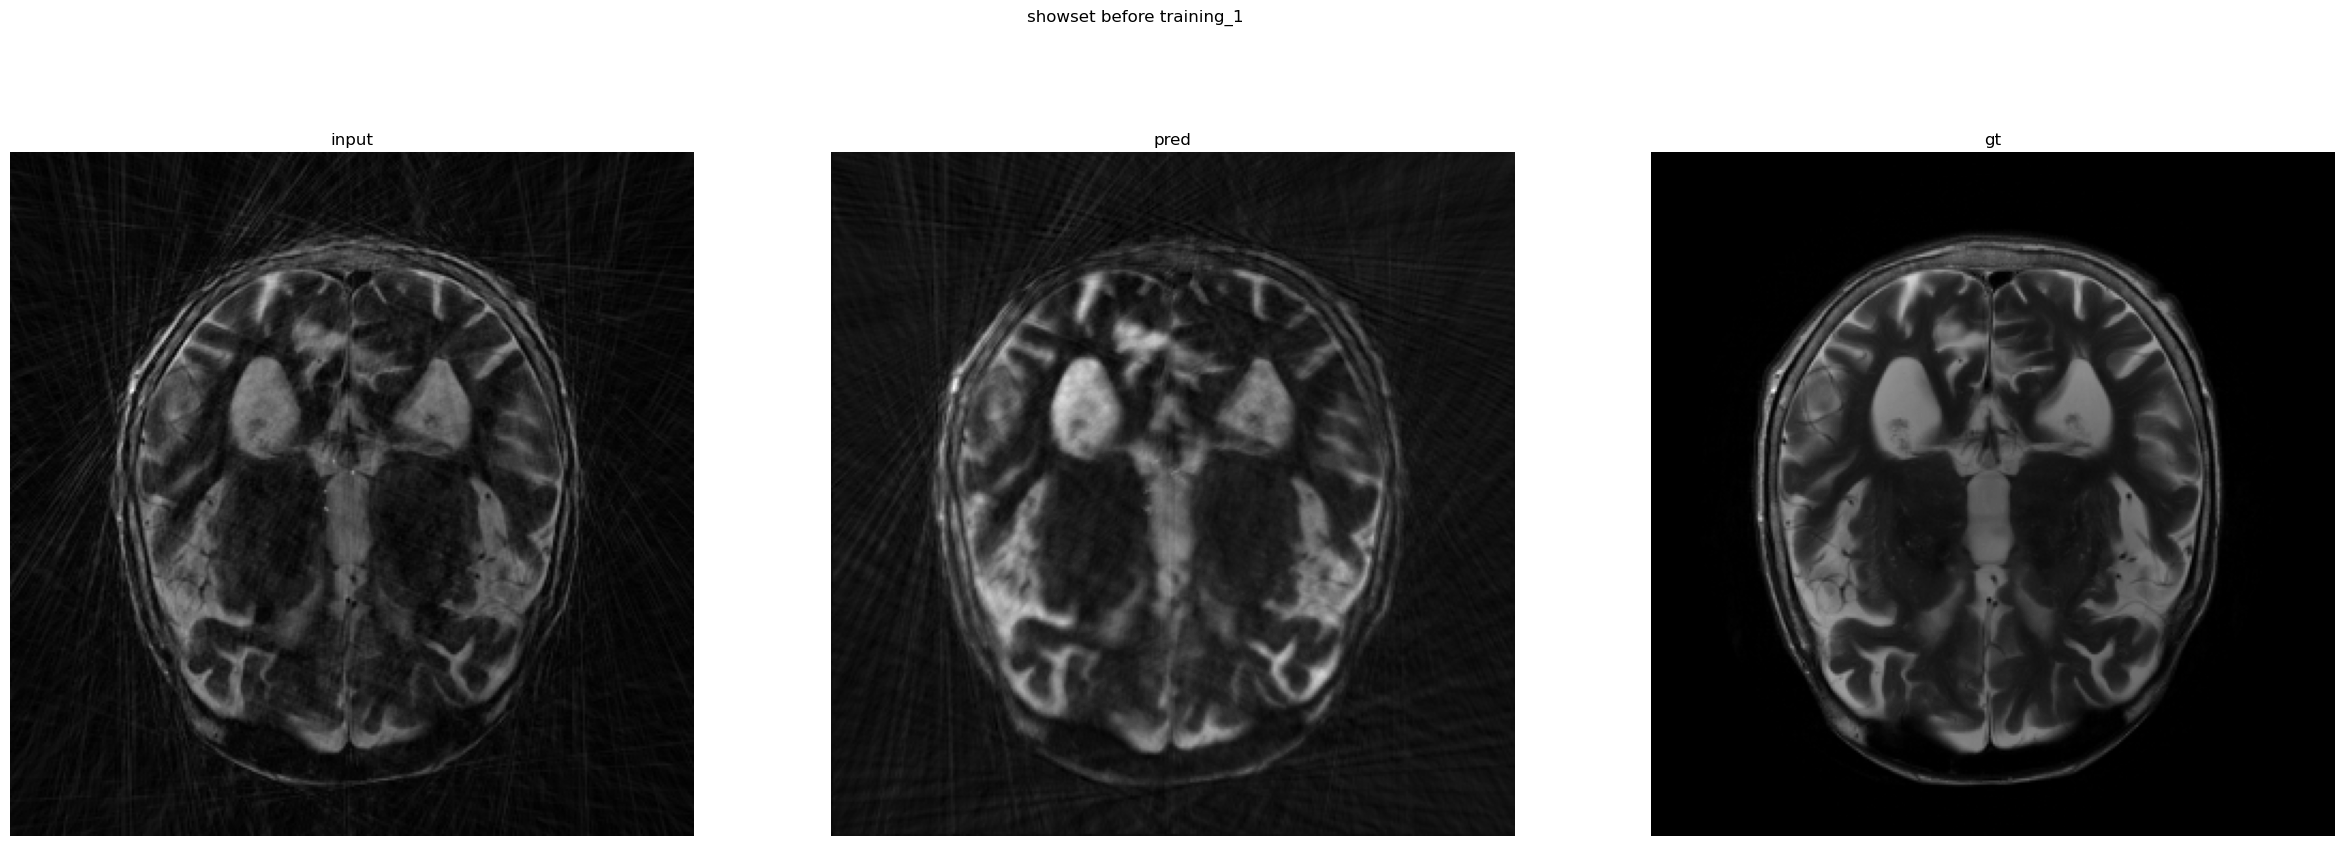

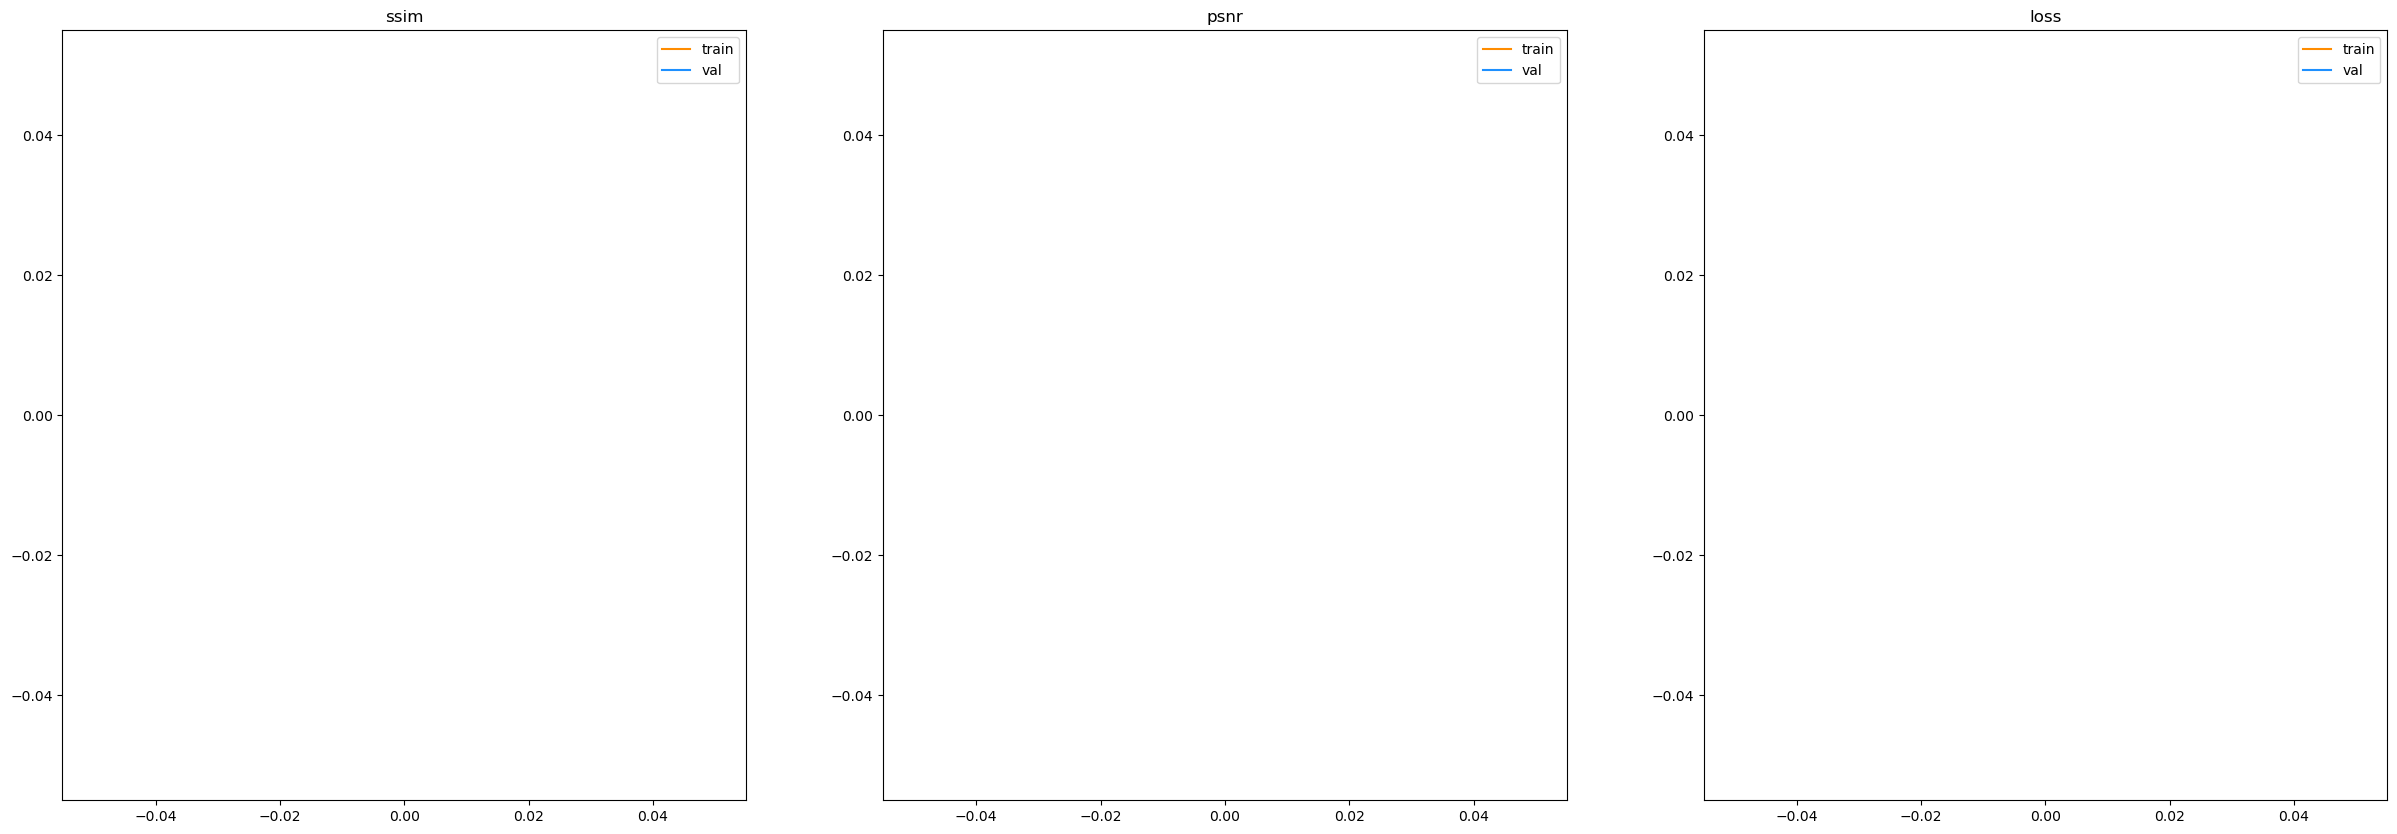

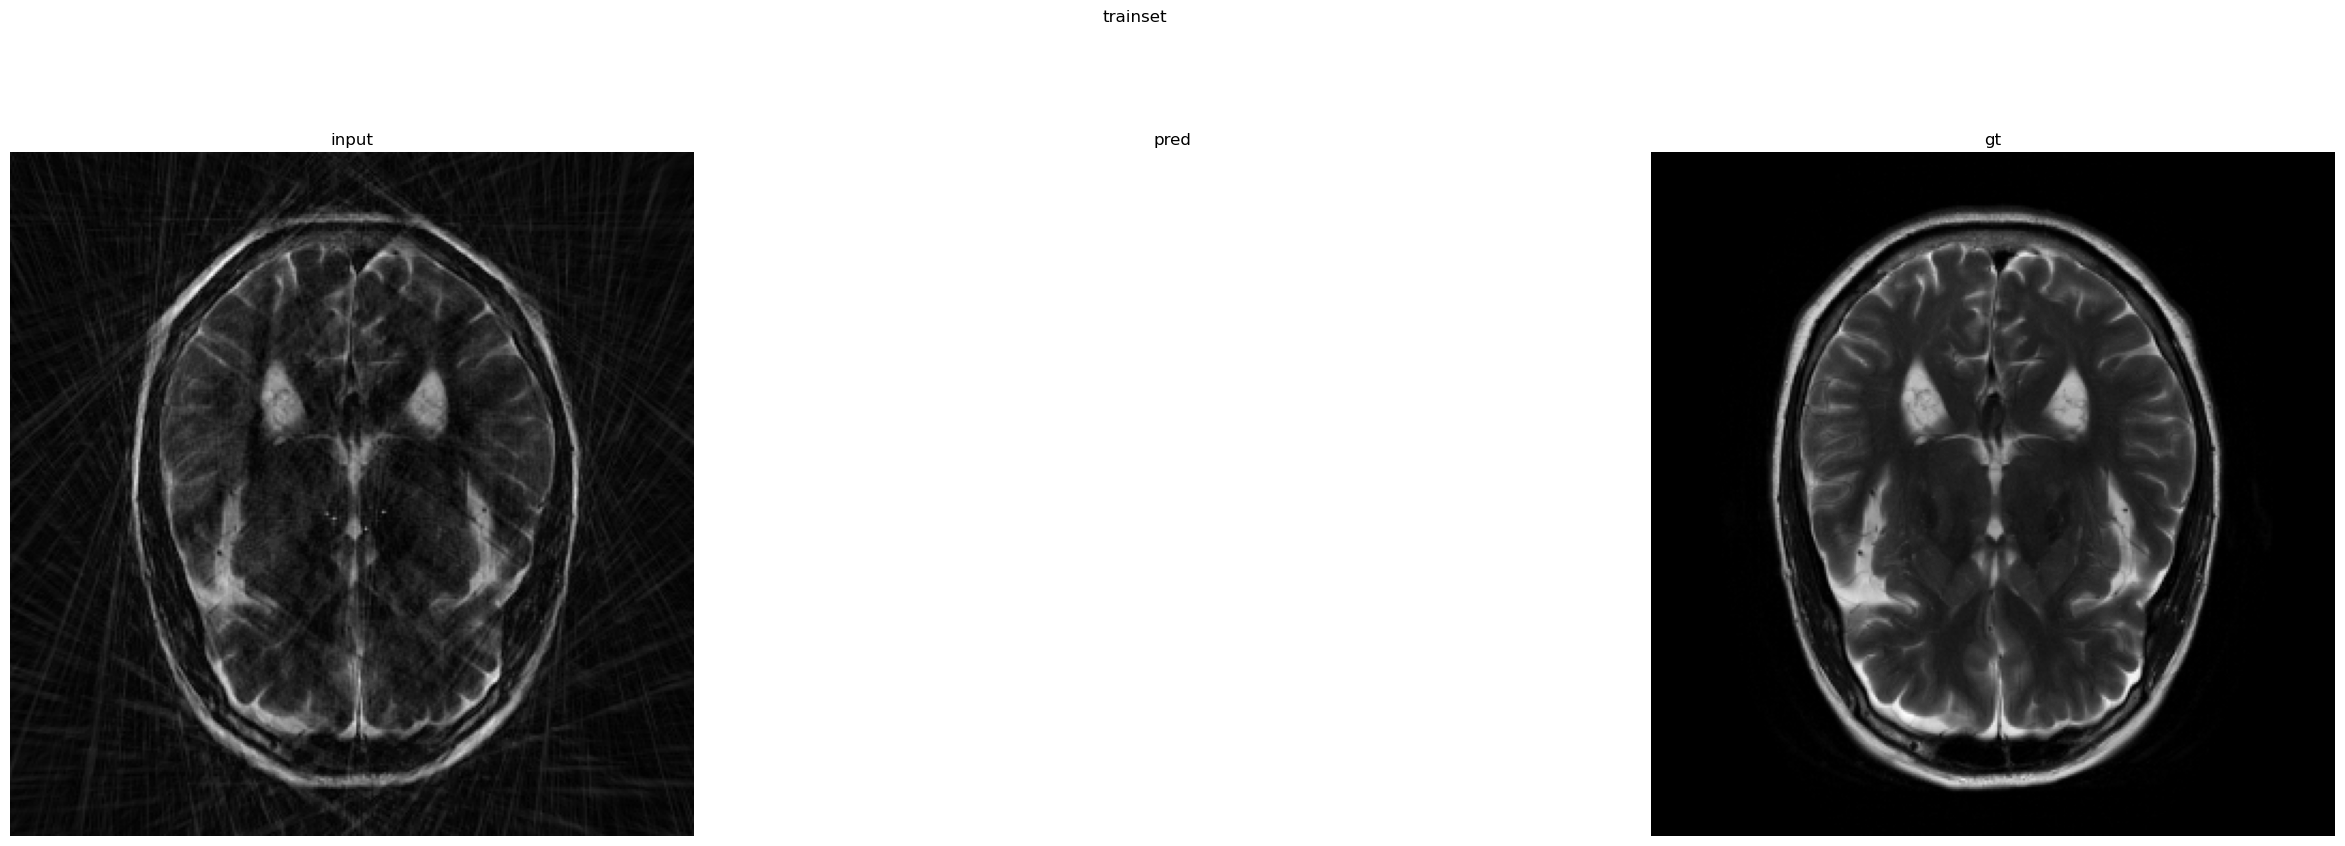

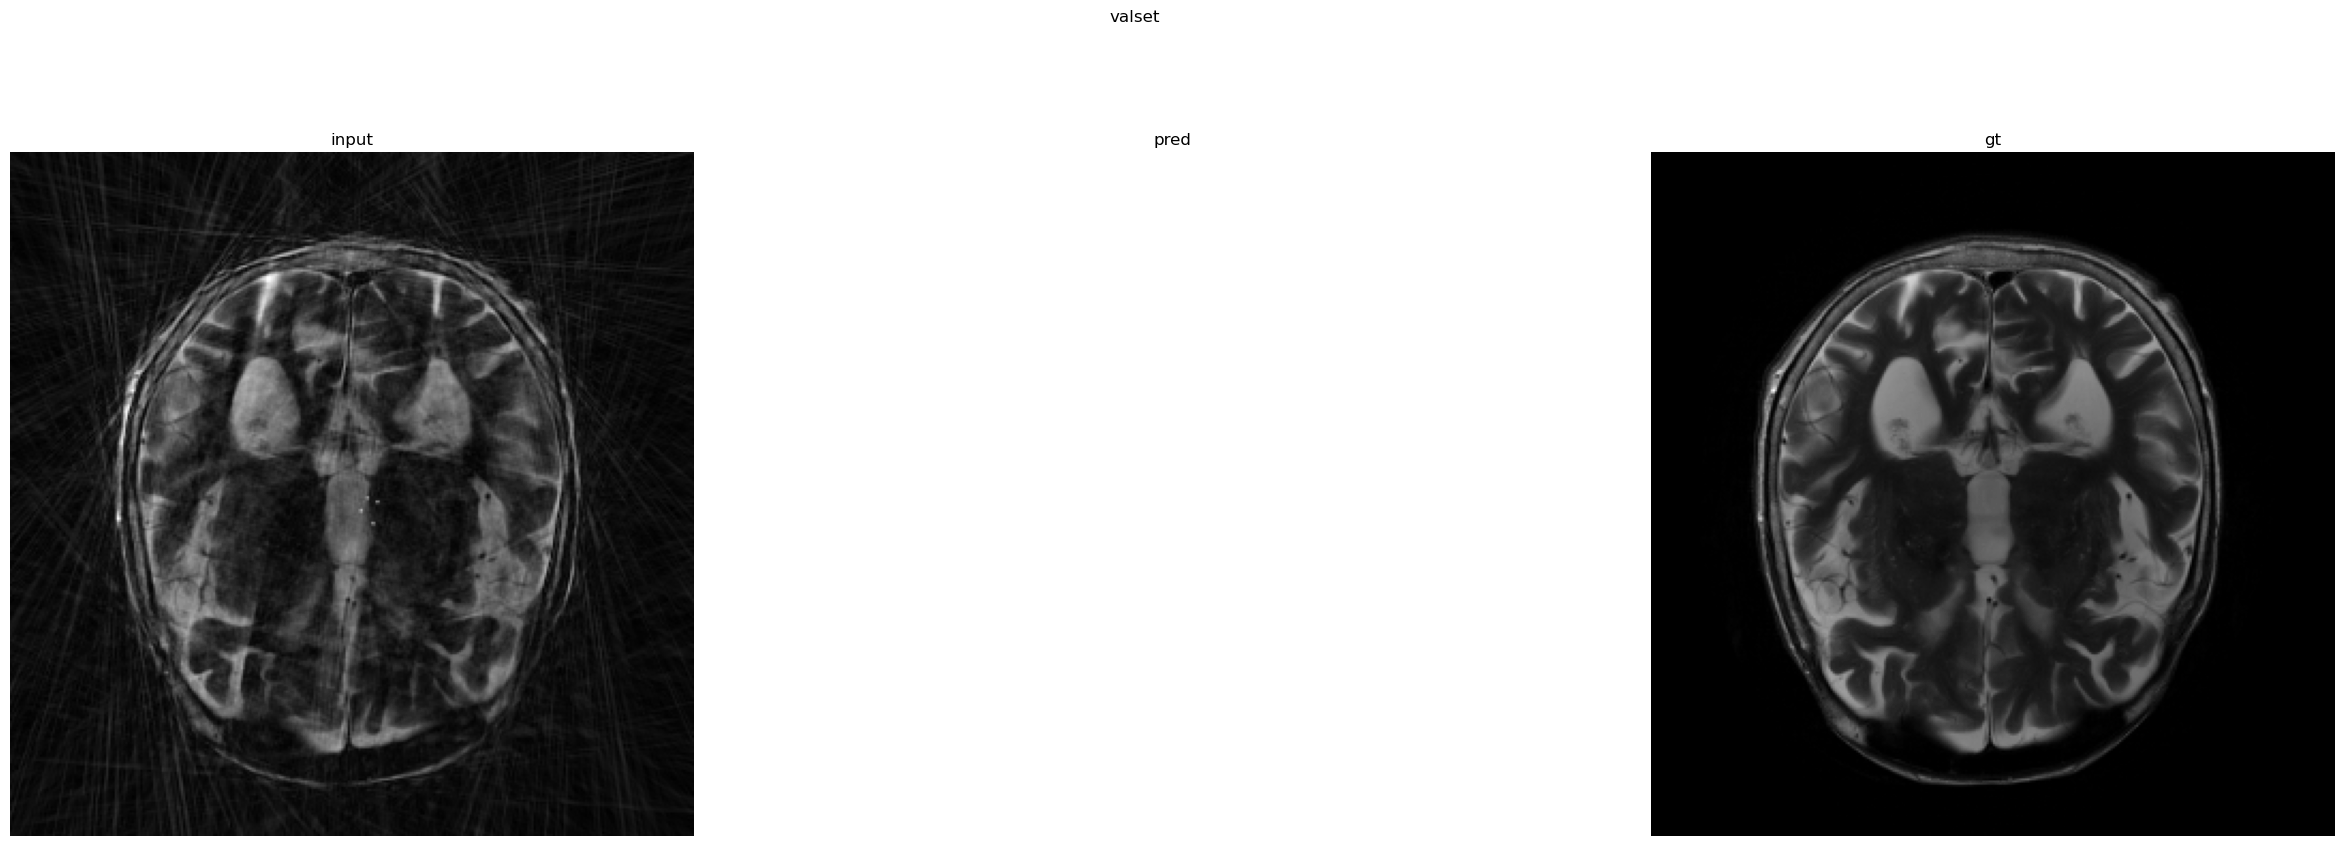

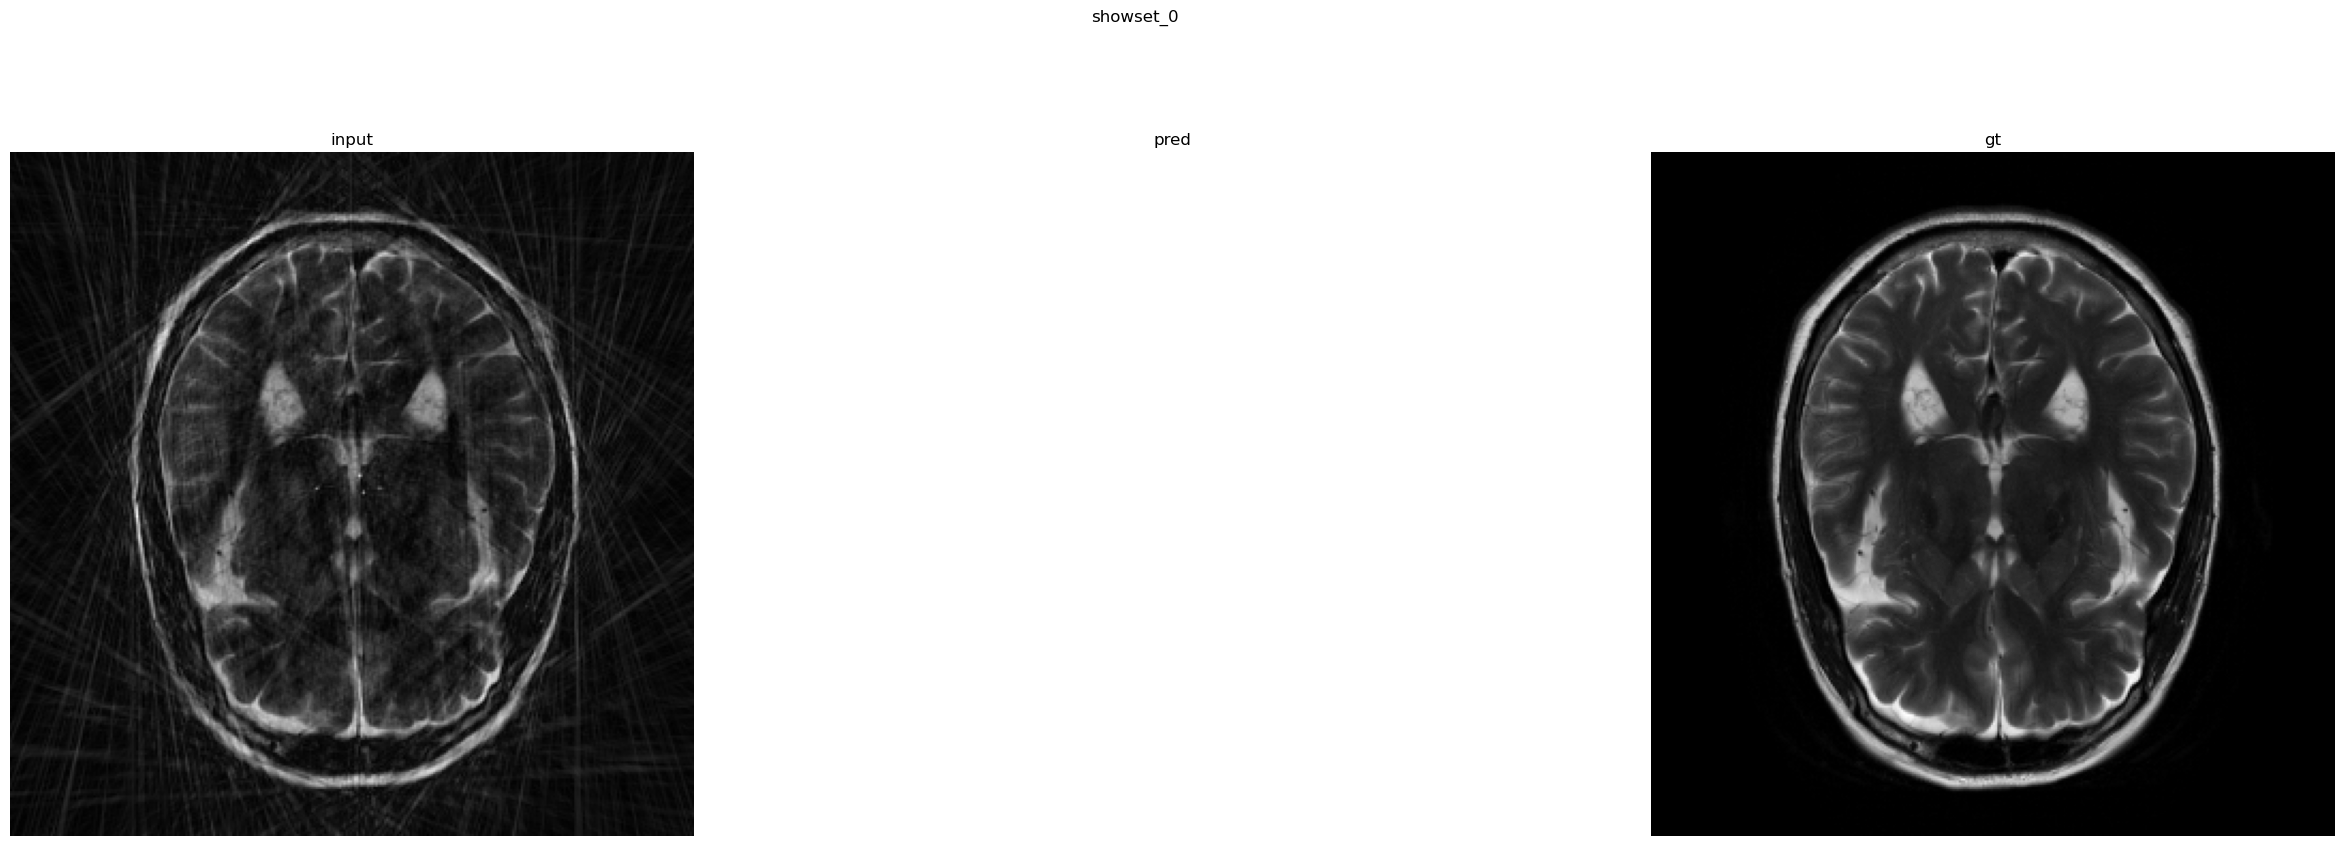

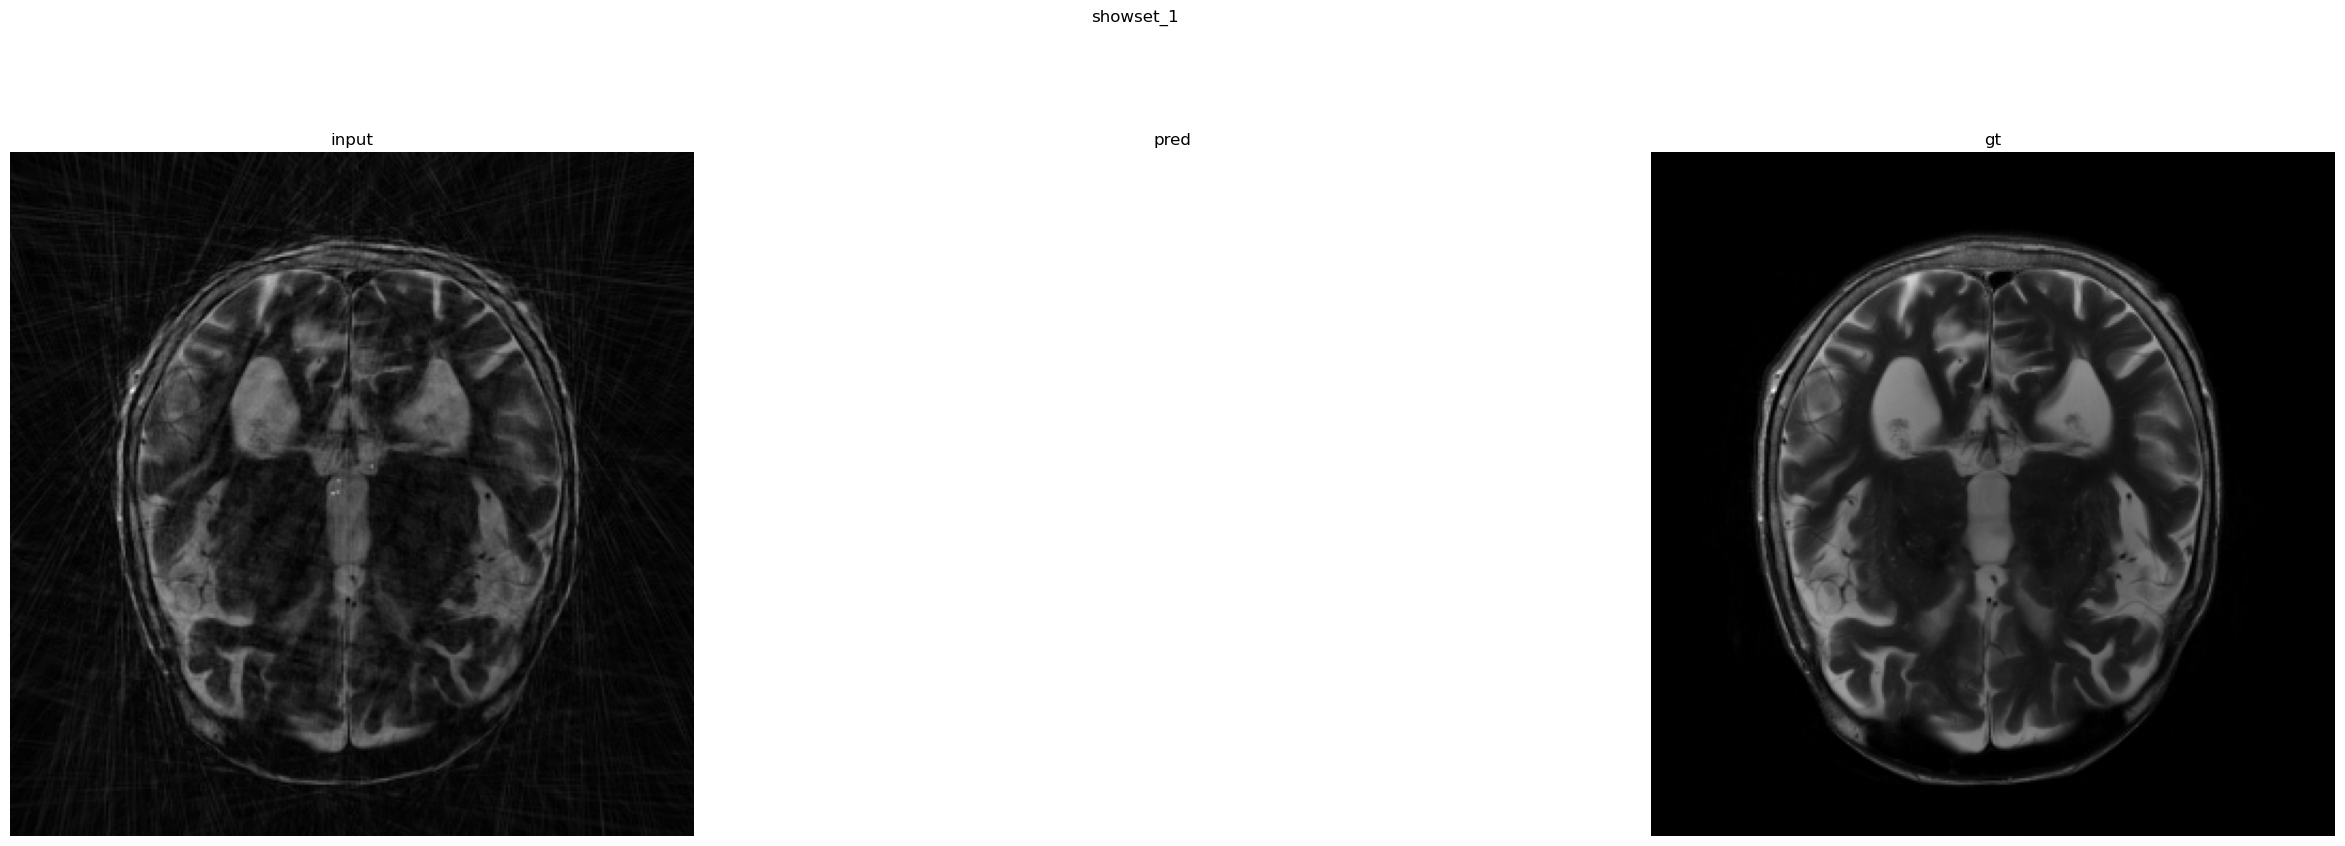

In [5]:
from doctest import debug
from torch import nn
import models
from models import mynn as mynn
from models.mynn import functional as myf
from train import train
from datasets import Fastmri_320p

class MyModel(nn.Module):
    def __init__(self, in_channels : int = 16, out_channels : int = 16 , depth : int = 4, top_channels : int = 64, dtype = torch.float32, crop_res = False):
        super().__init__()
        self.unet_real = models.UNet(in_channels=in_channels, out_channels=out_channels, depth=depth, top_channels=top_channels, dtype=dtype, crop_res=crop_res,
                                norm_layer=None,
                                act_layer=nn.ReLU)
        self.unet_imag = models.UNet(in_channels=in_channels, out_channels=out_channels, depth=depth, top_channels=top_channels, dtype=dtype, crop_res=crop_res,
                                norm_layer=None,
                                act_layer=nn.ReLU)
        self.r2c = mynn.Real2Complex()
        self.c2r = mynn.Complex2Real()
        
    def forward(self, data):
        real = data.real
        imag = data.imag
        real = self.unet_real(real)
        imag = self.unet_imag(imag)
        data = real + 1j * imag
        return data

data_augmentation = DataAugmentation(Motion(device=device))

trainset = Fastmri_320p(trainlist, transform=Loadtransform(), disk_cache = True, debug = False)
valset = Fastmri_320p(vallist, transform = Loadtransform(), disk_cache = True, debug = False)
showset = Fastmri_320p(showlist, transform = Loadtransform())

model = MyModel()

ssim_fn = mynn.loss.MS_SSIM(data_range=1.0, channel=32)

def loss_fn(pred, true):
    pred = mynn.complex_to_real(pred)
    true = mynn.complex_to_real(true)
    return 1-ssim_fn(pred,true)

def rsos(x):
    return torch.sqrt(torch.sum(x.abs()**2, dim=1,keepdim=True))

def show_transform(pred, y, x=None):
    # 1 C H W
    if x is not None:
        x = rsos(x)
    y = rsos(y)
    pred = rsos(pred)
    if x is not None:
        return pred, y, x 
    return pred, y 

train(
    model=model,
    train_dataset=trainset,
    val_dataset=valset,
    loss_fn=loss_fn,
    epochs=11,
    lr = 0.01,
    exp_name='unet_radial_moco',
    batch_size = 8,
    epoch_length=640 // 8,
    eval_length_train=64 // 8,
    eval_length_val=64 // 8,
    loader_num_workers=16,
    prefetch_factor=16,
    augmentation_transform=data_augmentation,
    input_transform=lambda data:(data['image_after'], data['image_before']),
    metric_transform=lambda x : x.abs(),
    show_transform=show_transform,
    extra_info={'test':"1"},
    imshow_dataset=showset,
    device=device
    )
    
        